In [1]:
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import IPython
from IPython.display import display, clear_output
from matplotlib import rcParams
import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from packages.data_generation import DG
from packages.Classifier import Perceptron, SVM, Logistic
#from packages.Optimizers import Perceptron, SVM, Logistic
#from packages.Kernels import RBF, Polynomial, Linear
from packages.Util import CrossVal, GD
from packages.Regularizers import L1, L2

from sklearn import svm
from sklearn import datasets
import sklearn
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso, SGDClassifier, Ridge

## Linearly-seperable data 

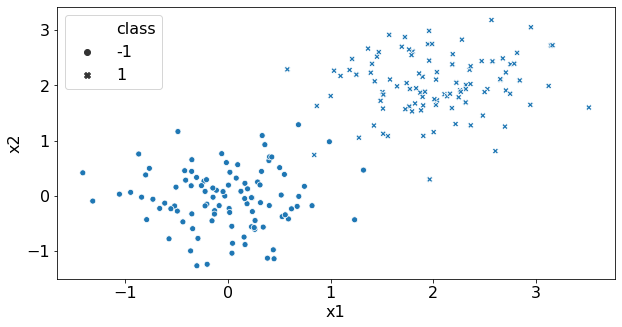

In [6]:
N = 100
data = DG(N, 0.2, 2)
X, Y = data.linear_seperable(0, 0.5, 2)
X_df = pd.DataFrame(X, columns=['x1', 'x2','intercept'])
Y_df = pd.DataFrame(Y, columns=['class'])
XY = pd.concat((X_df, Y_df),axis=1)
sns.scatterplot(x='x1', y='x2', style='class', data=XY) #plot with seaborn

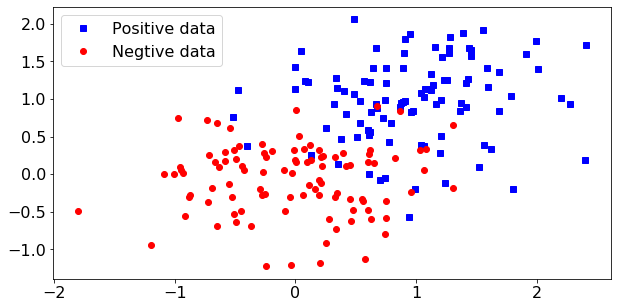

In [32]:
rcParams['figure.figsize'] = (10, 5)   # Change this if figures look ugly. 
rcParams['font.size'] = 16
N = 100
data = DG(N, 0.2, 2)
X, Y = data.linear_seperable(0, 0.5, 5)
#X[:,0] = X[:,0]*10
#X[:,1] = X[:,1]*10
fig, ax = plt.subplots()
#ax.plot(X[np.where(Y==1)[0], 0 ], X[np.where(Y==1)[0], 1], 'bs', label='Positive data')
#ax.plot(X[np.where(Y==-1)[0], 0 ], X[np.where(Y==-1)[0], 1], 'ro', label='Negtive data')
ax.plot(X[Y==1][:,0], X[Y==1][:,1], 'bs', label='Positive data')
ax.plot(X[Y==-1][:,0], X[Y==-1][:,1], 'ro', label='Negtive data')
ax.legend()

## Train/Test split

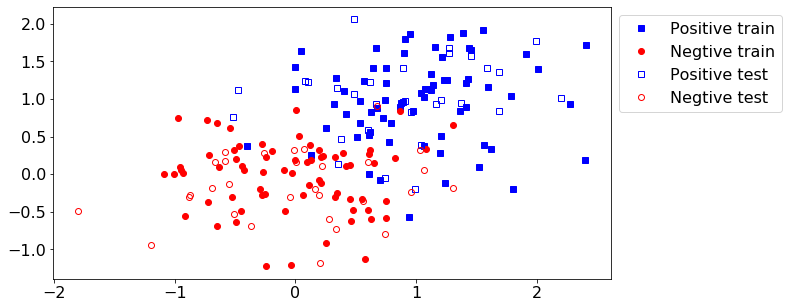

In [33]:
train_num = int(N * 0.7)
ind_p = np.arange(N)
np.random.shuffle(ind_p)
ind_n = ind_p + N
train_ind = np.concatenate((ind_p[:train_num], ind_n[:train_num]))
val_ind = np.concatenate((ind_p[train_num:], ind_n[train_num:]))
X_train, Y_train = X[train_ind,:], Y[train_ind]
X_val, Y_val = X[val_ind,:], Y[val_ind]
fig, ax1 = plt.subplots()
ax1.plot(X_train[np.where(Y_train==1)[0], 0 ], X_train[np.where(Y_train==1)[0], 1], 'bs', label='Positive train')
ax1.plot(X_train[np.where(Y_train==-1)[0], 0 ], X_train[np.where(Y_train==-1)[0], 1], 'ro', label='Negtive train')

ax1.plot(X_val[np.where(Y_val==1)[0], 0 ], X_val[np.where(Y_val==1)[0], 1], 'bs', fillstyle='none',label='Positive test')
ax1.plot(X_val[np.where(Y_val==-1)[0], 0 ], X_val[np.where(Y_val==-1)[0], 1], 'ro',fillstyle='none', label='Negtive test')
ax1.legend(bbox_to_anchor=(1, 1))

# Perceptron
Perceptron rules the classification algorithm before SVM emerges! The two algorithms are quite similar. Perceptron take the loss: $$L_p(w)=\frac{1}{N}\sum_{i=1}^N l_i(w),~~~ where ~~~l_i(w)=\max\{0,-y_iw^Tx_i\}$$
The sub-gradient of perceptron loss at the position $w$ is given by
$$ \partial L_p(w; x_i,y_i) = \partial l_i(w)=\left\{\begin{array}{cc} 0 & \text{if } -y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } -y_i w^\top x_i > 0 \\ -\alpha y_i x_i & \text{if } -y_i w^\top x_i = 0 \end{array}  \right. $$
where $\alpha \in \left[0,1\right]$

In [11]:
n_widget = ipywidgets.IntSlider(value=50, min=20, max=500, step=20, description='Iterations')
bs_widget = ipywidgets.IntSlider(value=1, min=1, max=X_train.shape[0], step=1, description='Batch size')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
reg_widget = ipywidgets.FloatLogSlider(value=0.000001, base=10, min=-6, max=3, step=0.1, description='Regularization')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

def para_interact(iter_n, bs, eta0, reg, lrm):
    np.random.seed(42)
    w0 = np.random.randn(3)
    opts = {'eta0': eta0,
           'batchsize': bs,
           'iter': iter_n,
           'learning rate': lrm}
    optimizer = Perceptron(X_train, Y_train)
    regularizer = L2(reg)
    w_hat = GD(w0, optimizer, regularizer, opts)[-1]
    print(w_hat)
    #Y1 = optimizer.predict(X_val, w_hat)
    fig, ax1 = plt.subplots()
    
    min1, max1 = X_val[:,0].min()-1., X_val[:,0].max()+1.
    min2, max2 = X_val[:,1].min()-1., X_val[:,1].max()+1.
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid) #same shape
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    grid = np.concatenate((grid, intercept_c), axis=1)
    #print(grid.shape)
    Y1 = optimizer.predict(grid, w_hat) #predict returns only {-1,1} so there will be a clear decision boundary at 0.
    zz = Y1.reshape(xx.shape)
    c = ax1.contourf(xx, yy, zz, cmap="RdBu", alpha=0.6)
    plt.colorbar(c)
    ax1.plot(X_train[np.where(Y_train==1)[0], 0 ], X_train[np.where(Y_train==1)[0], 1], 'bs', label='Positive train')
    ax1.plot(X_train[np.where(Y_train==-1)[0], 0 ], X_train[np.where(Y_train==-1)[0], 1], 'ro', label='Negtive train')

    ax1.plot(X_val[np.where(Y_val==1)[0], 0 ], X_val[np.where(Y_val==1)[0], 1], 'bs', fillstyle='none',label='Positive test')
    ax1.plot(X_val[np.where(Y_val==-1)[0], 0 ], X_val[np.where(Y_val==-1)[0], 1], 'ro',fillstyle='none', label='Negtive test')
    ax1.legend(bbox_to_anchor=(1, 1))
    
interact(para_interact, iter_n=n_widget, bs=bs_widget, eta0=eta_widget, reg=reg_widget, lrm=lrm_widget)  

interactive(children=(IntSlider(value=50, description='Iterations', max=500, min=20, step=20), IntSlider(value…

<function __main__.para_interact(iter_n, bs, eta0, reg, lrm)>

# SVM
SVM tackles the problem that cannot be solved by perceptron when data is not linearly-seperable. At this case soft-SVM (structured SVM for more complicated cases) emerges to help. It does not only seperate the data with the maximal margin but also allow some level of cushion. The loss function of SVM is called **Hinge loss**:
$$L(w) = \frac{1}{N}\sum_{i=1}^N l_i(w),~~~where~~~l_i(w)=\max\{0,1-y_iw^Tx_i\}$$
The sub-gradient of hinge loss at the position $w$ is given by
$$ \partial L_p(w; x_i,y_i) = \partial l_i(w)=\left\{\begin{array}{cc} 0 & \text{if } 1-y_i w^\top x_i < 0 \\ -y_i x_i & \text{if } 1-y_i w^\top x_i > 0 \\  -\alpha y_i x_i & \text{if } 1-y_i w^\top x_i = 0 \end{array}  \right. $$
where $\alpha \in \left[0,1\right]$

In [4]:
n_widget = ipywidgets.IntSlider(value=50, min=10, max=500, step=5, description='Iterations')
bs_widget = ipywidgets.IntSlider(value=1, min=1, max=X_train.shape[0], step=1, description='Batch size')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
reg_widget = ipywidgets.FloatLogSlider(value=0.000001, base=10, min=-6, max=3, step=0.1, description='Regularization')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

def para_interact(iter_n, bs, eta0, reg, lrm):
    np.random.seed(42)
    w0 = np.random.randn(3)
    opts = {'eta0': eta0,
           'batchsize': bs,
           'iter': iter_n,
           'learning rate': lrm}
    optimizer = SVM(X_train, Y_train)
    regularizer = L2(reg)
    w_hat = GD(w0, optimizer, regularizer, opts)[-1]
    print(f'coefficients:{w_hat}')
    print(optimizer.loss(w_hat))
    fig, ax1 = plt.subplots()
    min1, max1 = X_val[:,0].min()-1, X_val[:,0].max()+1
    min2, max2 = X_val[:,1].min()-1, X_val[:,1].max()+1
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = optimizer.predict(grid, w_hat)
    zz = Y1.reshape(xx.shape)
    c = ax1.contourf(xx, yy, zz, cmap='Paired')
    #plt.colorbar(c)
    ax1.plot(X_train[np.where(Y_train==1)[0], 0 ], X_train[np.where(Y_train==1)[0], 1], 'bs', label='Positive train')
    ax1.plot(X_train[np.where(Y_train==-1)[0], 0 ], X_train[np.where(Y_train==-1)[0], 1], 'ro', label='Negtive train')

    ax1.plot(X_val[np.where(Y_val==1)[0], 0 ], X_val[np.where(Y_val==1)[0], 1], 'bs', fillstyle='none',label='Positive test')
    ax1.plot(X_val[np.where(Y_val==-1)[0], 0 ], X_val[np.where(Y_val==-1)[0], 1], 'ro',fillstyle='none', label='Negtive test')
    ax1.legend(bbox_to_anchor=(1, 1))
    
interact(para_interact, iter_n=n_widget, bs=bs_widget, eta0=eta_widget, reg=reg_widget, lrm=lrm_widget)  

interactive(children=(IntSlider(value=50, description='Iterations', max=500, min=10, step=5), IntSlider(value=…

<function __main__.para_interact(iter_n, bs, eta0, reg, lrm)>

As seen above two examples, if we generate linearly-seperable data with distant mean, SVM will give a decision boundary with clear margin, but perceptron will only draw a classifier boundary that divides the two class.

# Logistic classification
In logistic algorithm, instead of using hardmax to be the target, we apply softmax:
$$\hat{f}(x)=Xw~~~ (in ~the ~linear~ kernel ~case)$$
$$\hat{p}(y=1)=softmax\big(\frac{-\hat{f}(x)}{2}, \frac{\hat{f}(x)}{2}\big)= \frac{1}{1+\exp(-\hat{f}(x))}$$
Easily we can obtain
$$\hat{p}(y=-1)=\frac{1}{1+\exp(\hat{f}(x))}$$
And the logistic loss is given by
$$l_{log}(y,\hat{f}(x))= \log(1+e^{-y\hat{f}(x)})$$
$$L(w) = \frac{1}{N}\sum_{i=1}^N l_i(w)$$
$$\nabla l(w)=\frac{-e^{-y_i\hat{f}(x_i)}y_i\hat{f^{'}}(x_i)}{1+e^{-y_i\hat{f}(x_i)}}$$

In [5]:
n_widget = ipywidgets.IntSlider(value=50, min=10, max=500, step=5, description='Iterations')
bs_widget = ipywidgets.IntSlider(value=1, min=1, max=X_train.shape[0], step=1, description='Batch size')
eta_widget = ipywidgets.FloatSlider(value=1, min=0.01, max=5., step=0.5, description='Learning rate')
reg_widget = ipywidgets.FloatLogSlider(value=0.000001, base=10, min=-6, max=3, step=0.1, description='Regularization')
lrm_widget = ipywidgets.ToggleButtons(options=['None', 'Adagrad', 'Annealing'], value='None', description='LR mode')

def para_interact(iter_n, bs, eta0, reg, lrm):
    np.random.seed(42)
    w0 = np.random.randn(3)
    opts = {'eta0': eta0,
           'batchsize': bs,
           'iter': iter_n,
           'learning rate': lrm}
    optimizer = Logistic(X_train, Y_train)
    regularizer = L2(reg)
    w_hat = GD(w0, optimizer, regularizer, opts)[-1]
    fig, ax1 = plt.subplots()
    
    min1, max1 = X_val[:,0].min()-0.5, X_val[:,0].max()+0.5
    min2, max2 = X_val[:,1].min()-0.5, X_val[:,1].max()+0.5
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    intercept_c = np.ones((grid.shape[0],1))
    grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = optimizer.predict(grid, w_hat)
    zz = Y1.reshape(xx.shape)
    c = plt.contourf(xx, yy, zz, cmap='RdBu', alpha=1)
    plt.colorbar(c)
    #c.set_clim(0.,1.)
    ax1.plot(X_train[np.where(Y_train==1)[0], 0 ], X_train[np.where(Y_train==1)[0], 1], 'bs', label='Positive train')
    ax1.plot(X_train[np.where(Y_train==-1)[0], 0 ], X_train[np.where(Y_train==-1)[0], 1], 'ro', label='Negtive train')

    ax1.plot(X_val[np.where(Y_val==1)[0], 0 ], X_val[np.where(Y_val==1)[0], 1], 'bs', fillstyle='none',label='Positive test')
    ax1.plot(X_val[np.where(Y_val==-1)[0], 0 ], X_val[np.where(Y_val==-1)[0], 1], 'ro',fillstyle='none', label='Negtive test')
    ax1.legend(bbox_to_anchor=(1.2, 1))
    
interact(para_interact, iter_n=n_widget, bs=bs_widget, eta0=eta_widget, reg=reg_widget, lrm=lrm_widget) 

interactive(children=(IntSlider(value=50, description='Iterations', max=500, min=10, step=5), IntSlider(value=…

<function __main__.para_interact(iter_n, bs, eta0, reg, lrm)>

Similarly to SVM, logistic classification will also produce a decision boundary with some margin.

# Multiclass classification

In [75]:
fier_widget = ipywidgets.ToggleButtons(options=['Perceptron', 'SVM'], value='SVM', description='Classifier')
method_widget = ipywidgets.ToggleButtons(options=['ovo', 'ovr', 'itself'], value='ovr', description='Method')
noise_widget = ipywidgets.FloatSlider(value=0.1, min=0, max=1, step=0.1, description='Noise level')
n_widget = ipywidgets.IntSlider(value=100, min=10, max=1000, step=10, description='Number of samples')

def multiclassi(classifier, method, n, noise):
    np.random.seed(10)
    X, Y = datasets.make_classification(n_samples=n,n_features=2, n_informative=2, n_redundant=0, n_repeated=0,
                                        n_classes=3, n_clusters_per_class=1,
                                        class_sep=2, random_state=23)
    X += noise * np.random.randn(n,2)
    if classifier == 'Perceptron':
        fier = SGDClassifier(loss='perceptron', alpha=0.0001, random_state=23)
    else:
        fier = svm.LinearSVC(loss='hinge', random_state=23)
    
    if method == 'ovo':
        classifier = OneVsOneClassifier(fier)
        colors = ['r', 'b', 'g']
    elif method == 'ovr':
        classifier = OneVsRestClassifier(fier)
        colors = ['r', 'b', 'g']
    else:
        classifier = fier
        colors = ['r', 'b', 'g']
    classifier.fit(X, Y)
    
    fig, ax1 = plt.subplots()
    min1, max1 = X[:,0].min()-0.5, X[:,0].max()+0.5
    min2, max2 = X[:,1].min()-0.5, X[:,1].max()+0.5
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    xx, yy = np.meshgrid(x1grid, x2grid)
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    grid = np.hstack((r1,r2))
    #intercept_c = np.ones((grid.shape[0],1))
    #grid = np.concatenate((grid, intercept_c), axis=1)
    Y1 = classifier.predict(grid)
    zz = Y1.reshape(xx.shape)
    c = plt.contourf(xx, yy, zz, cmap='rainbow',alpha=0.35)
    #plt.colorbar(c)
    ax1.plot(X[np.where(Y==0)[0], 0 ], X[np.where(Y==0)[0], 1], 'bs', label='0')
    ax1.plot(X[np.where(Y==1)[0], 0 ], X[np.where(Y==1)[0], 1], 'gs', label='1')
    ax1.plot(X[np.where(Y==2)[0], 0 ], X[np.where(Y==2)[0], 1], 'rs', label='2')
    ax1.legend(bbox_to_anchor=(1.2, 1))
interact(multiclassi, classifier=fier_widget, method=method_widget, n=n_widget, noise=noise_widget)

interactive(children=(ToggleButtons(description='Classifier', index=1, options=('Perceptron', 'SVM'), value='S…

<function __main__.multiclassi(classifier, method, n, noise)>